# Workload example: Monte-Carlo estimate of $\pi$

<img src="https://upload.wikimedia.org/wikipedia/commons/8/84/Pi_30K.gif" width="25%" align=left alt="PI monte-carlo estimate"/>

Let's assume we would like to estimate the number $\pi$ using a [Monte-Carlo method](https://en.wikipedia.org/wiki/Pi#Monte_Carlo_methods), i.e. obtain an estimate numerically based on a random sampling approach.

We take advantage of the geometrical fact that the area of a quarter circle with unit radius is $\pi/4$ and that the probability of randomly chosen points in a unit square to be inside the quarter circle is $\pi/4$ as well. So, for $N_{total}$ randomly chosen pairs $(x, y)$ with $x\in[0, 1)$ and $y\in[0, 1)$ we count the number $N_{circ}$ of pairs that satisfy $(x^2 + y^2) < 1$ and estimate $\pi \approx 4 \cdot N_{circ} / N_{total}$.

In [1]:
from pi_workload import define_pi_workload

In [2]:
define_pi_workload??

Signature: define_pi_workload(size_in_terabytes=0.25, chunk_size_in_megabytes=500)
Source:   
def define_pi_workload(size_in_terabytes=0.25, chunk_size_in_megabytes=500):
    """Calculate pi using a Monte Carlo method."""
    
    print("workload in giga bytes:", size_in_terabytes*1e12/1e9)
    print(f"{(size_in_terabytes*1e12)/(chunk_size_in_megabytes*1e6)} chunks to process")

    total_array_size = (int(size_in_terabytes * 1e12 / 8 / 2), 2)
    number_of_tasks = (size_in_terabytes * 1e12) / (chunk_size_in_megabytes * 1e6)
    array_chunk_size = (int(total_array_size[0] / number_of_tasks), 2)

    xy = dask.array.random.uniform(
        low=0.0, high=1.0,
        size=total_array_size,
        chunks=array_chunk_size
    )

    xy_inside_circle = (xy ** 2).sum(axis=1) < 1

    pi = 4 * xy_inside_circle.mean()

    return pi
File:      ~/Course-Data-Science-with-Dask/03_distributed/pi_workload.py
Type:      function


## Task graph

In [3]:
pi = define_pi_workload(
size_in_terabytes = 0.001,
chunk_size_in_megabytes = 150
)

workload in giga bytes: 1.0
6.666666666666667 chunks to process


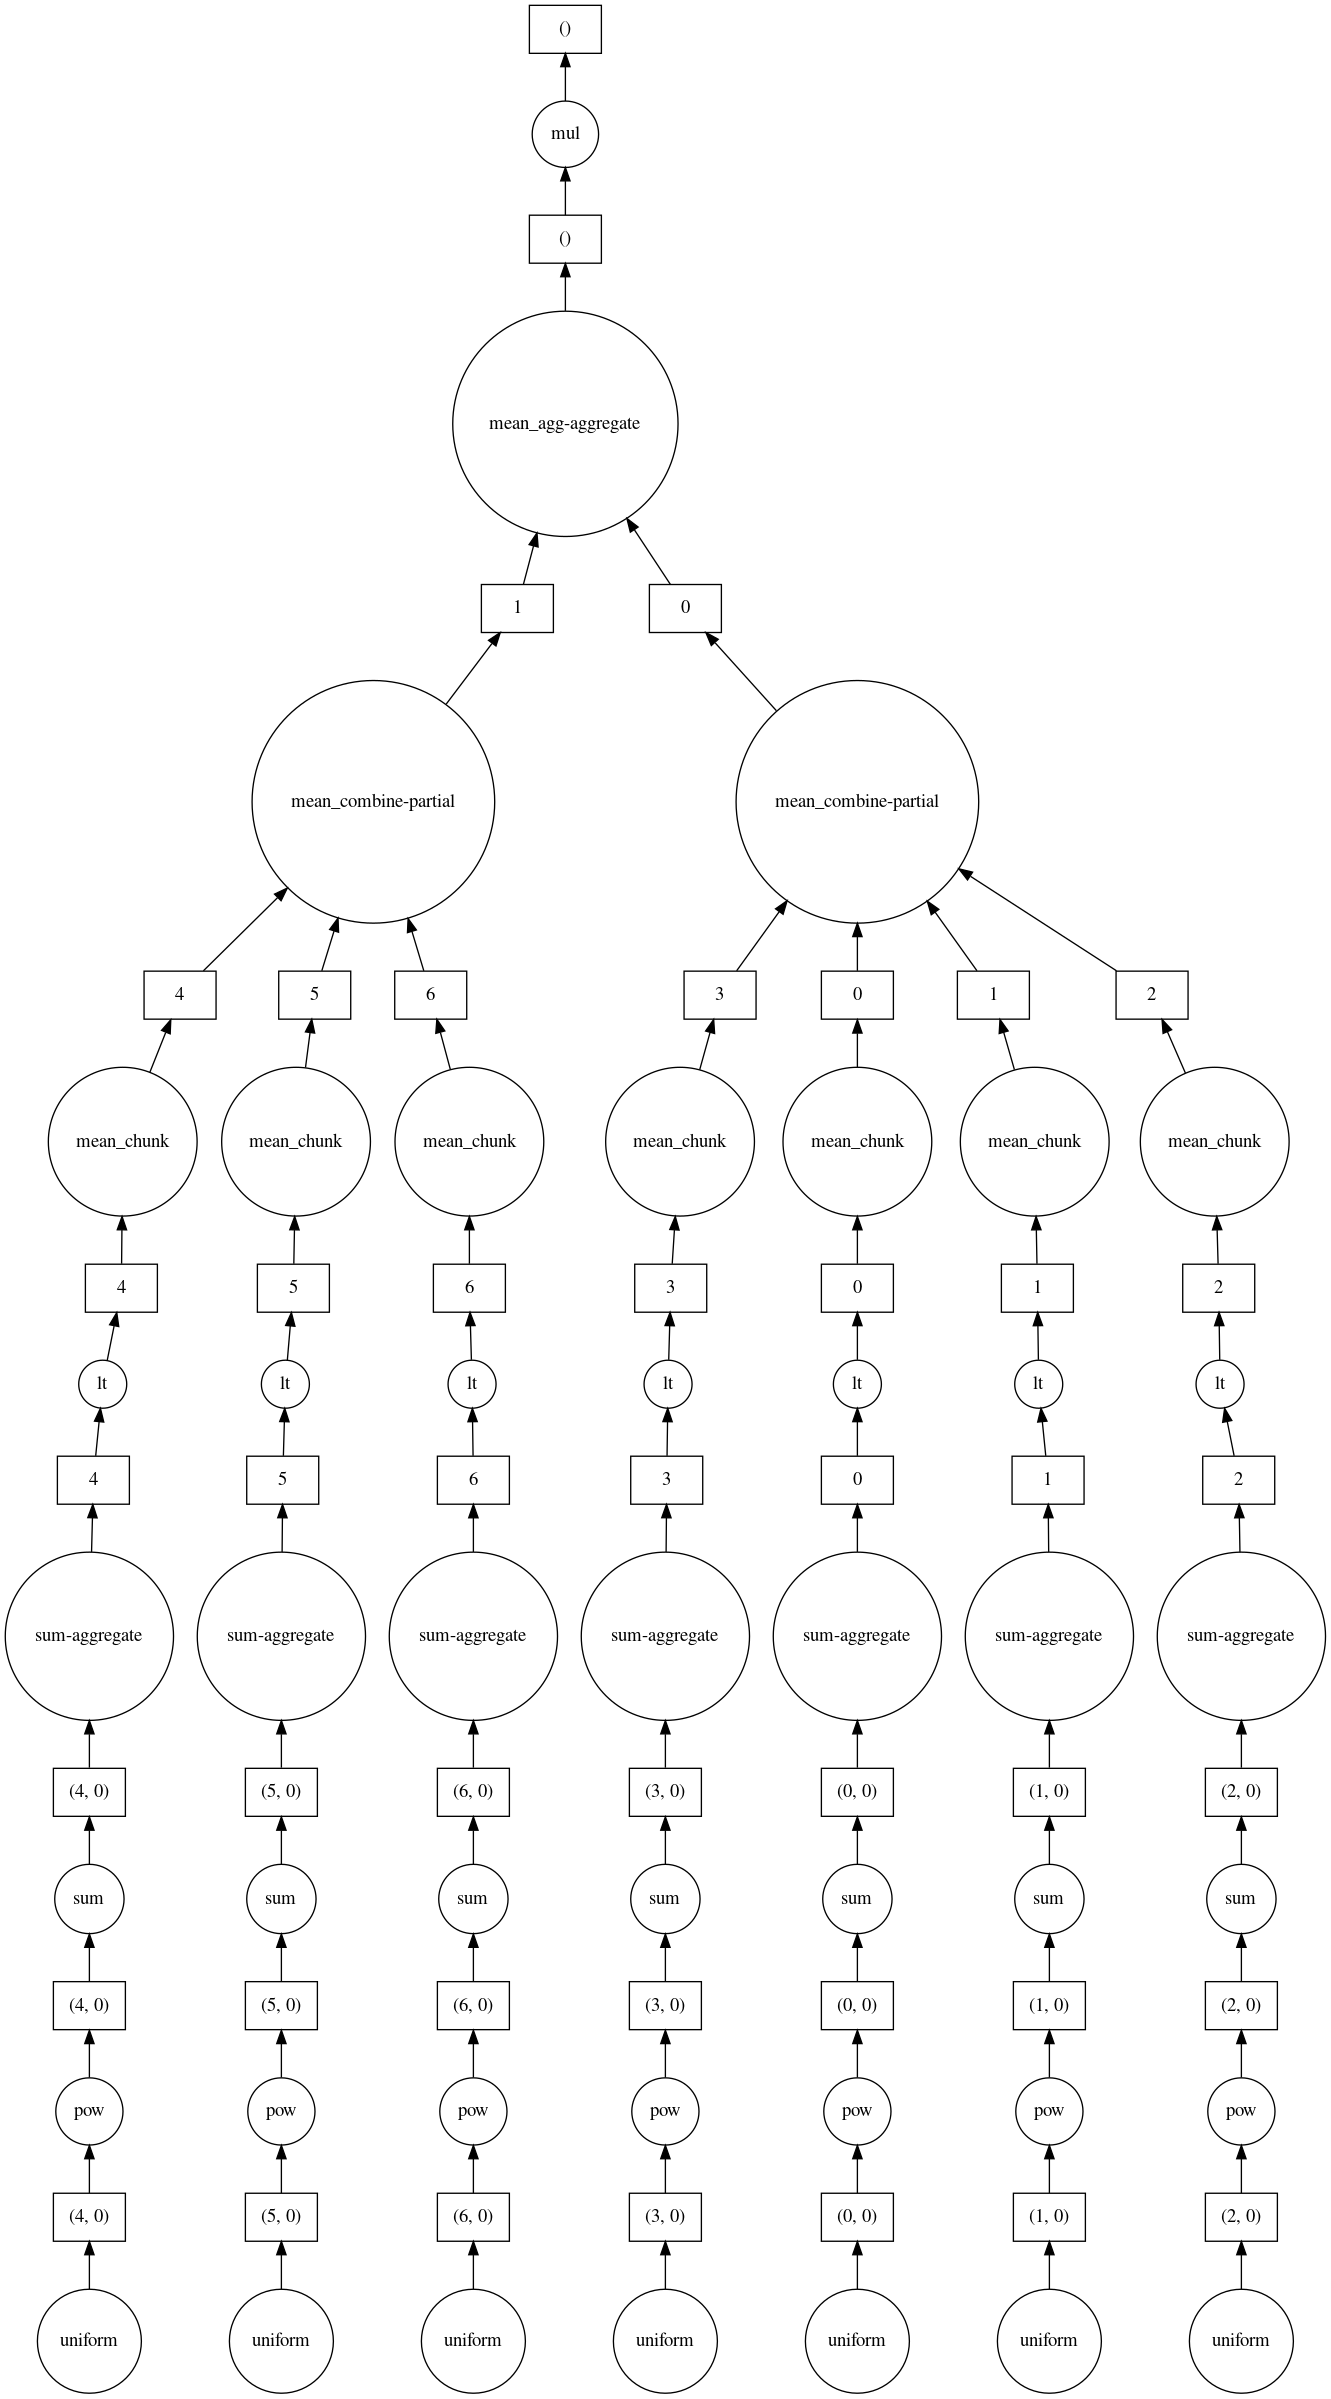

In [4]:
pi.visualize()

## Default workload characteristics

In [5]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:          125Gi       739Mi       122Gi        36Mi       2.2Gi       123Gi
Swap:         8.0Gi       186Mi       7.8Gi


In [6]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              16
On-line CPU(s) list: 0-15
Thread(s) per core:  1
Core(s) per socket:  1
Socket(s):           16
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz
Stepping:            0
CPU MHz:             2394.375
BogoMIPS:            4788.75
Hypervisor vendor:   VMware
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            28160K
NUMA node0 CPU(s):   0-15
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon nopl xtopology tsc_reliable nonstop_tsc cpuid pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor l

For performance reasons, i.e. to avoid excessive disk spilling and to allow for task execution at all (see [02_single-machine.ipynb](02_single-machine.ipynb) for a bad example), Dask array chunks should fit several times per utilized CPU into a Dask worker's memory. For a machine with the above characteristics a value below

In [7]:
this_is_several_times = 10

machine_mem = 125 # GiB
machine_cpus = 16
conversion_factor = 2**30 / 10**6

max_chunk_size = (machine_mem/machine_cpus)/this_is_several_times*conversion_factor # MB
print(f"{max_chunk_size} MB")

838.8607999999999 MB


should be sufficient.

Note, we have specified a default workload about twice as big as the memory that is available on the local machine (so that there is a bit to do here!) and a Dask array chunk size of 500 MB, i.e.

In [8]:
define_pi_workload?

Signature: define_pi_workload(size_in_terabytes=0.25, chunk_size_in_megabytes=500)
Docstring: Calculate pi using a Monte Carlo method.
File:      ~/Course-Data-Science-with-Dask/03_distributed/pi_workload.py
Type:      function


## Python environment

In [9]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
@EXPLICIT
https://conda.anaconda.org/conda-forge/linux-64/_libgcc_mutex-0.1-conda_forge.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ca-certificates-2020.11.8-ha878542_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ld_impl_linux-64-2.35.1-hed1e6ac_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgfortran5-9.3.0-he4bcb1c_17.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libstdcxx-ng-9.3.0-h2ae2ef3_17.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/pandoc-2.11.1.1-h36c2ea0_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgfortran-ng-9.3.0-he4bcb1c_17.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgomp-9.3.0-h5dbcf3e_17.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/_openmp_mutex-4.5-1_gnu.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgcc-ng-9.3.0-h5dbcf3e_17.tar.bz2
ht